In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Strumenti di classificazione
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Feature audio avanzate
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

In [2]:
# Segnaposto per feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

Features presenti già nel notebook:

In [3]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def sdev(input):
    return np.std(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

def duration(input):
    return input.shape

# Zero-Crossing Rate (ZCR)
Il Feature ZCR in un segnale discreto e finito $s_0,...,s_n$ è definito come:
    $$Z = \dfrac{1}{2}\sum_{i=1}^n |\text{sign}(s_i) - \text{sign}(s_{i-1})|$$
espandendo un forma vettoriale:
    $$Z = \dfrac{1}{2}\text{sum}(\text{abs}([s_1, s_2, ..., s_n] - [s_0, s_1, ..., s_{n-1}]))$$

In [4]:
#usiamo diff di numpy che fa già la differenza come serve a noi
def zcr(input):
    return np.sum(np.abs(np.diff(input, n=1)), keepdims=True)/2

In [5]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input)))

def combo_with_zcr(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr(input)))

# SVM Training (with ZCR vs without ZCR)

In [6]:
X_train_zcr, X_test_zcr, y_train_zcr, y_test_zcr =\
                                   load_data(feature_extractor=combo_with_zcr)
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo)

In [7]:
print("Without ZCR we have", X_train[0].shape[0], "elements")
print("With ZCR we have", X_train_zcr[0].shape[0], "elements")

Without ZCR we have 4 elements
With ZCR we have 5 elements


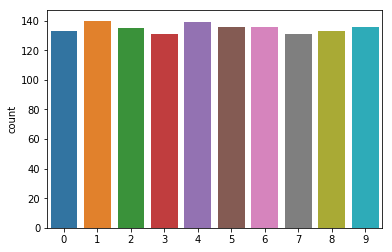

In [8]:
#controllo se le feature sono bilanciate
import seaborn as sns
sns.countplot(y_train)
plt.show()

In [9]:
# Parametri da provare in cross validation
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf_zcr = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf_zcr = clf_zcr.fit(X_train_zcr, y_train_zcr)
print('best parameters', clf_zcr.best_params_)
print("Addestramento completato in %0.3fs" % (time() - t0))

best parameters {'C': 1000, 'gamma': 0.1}
Addestramento completato in 3.644s


In [10]:
# Parametri da provare in cross validation
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf_no_zcr = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Addestramento
t0 = time()
clf = clf_no_zcr.fit(X_train, y_train)
print('best parameters', clf.best_params_)
print("Addestramento completato in %0.3fs" % (time() - t0))

best parameters {'C': 1000, 'gamma': 0.5}
Addestramento completato in 4.144s


# Testing

In [11]:
y_pred = clf_no_zcr.predict(X_test)

# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test, y_pred))
#testing the model without ZCR

Report di classificazione:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.33      0.40      0.36        10
           2       0.28      0.33      0.30        15
           3       0.53      0.42      0.47        19
           4       0.36      0.45      0.40        11
           5       0.44      0.29      0.35        14
           6       0.79      0.79      0.79        14
           7       0.80      0.42      0.55        19
           8       0.35      0.41      0.38        17
           9       0.32      0.43      0.36        14

    accuracy                           0.46       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150



Report di classificazione:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.29      0.50      0.37        10
           2       0.78      0.47      0.58        15
           3       0.75      0.63      0.69        19
           4       0.35      0.55      0.43        11
           5       0.54      0.50      0.52        14
           6       0.83      0.71      0.77        14
           7       0.58      0.58      0.58        19
           8       0.43      0.35      0.39        17
           9       0.50      0.64      0.56        14

    accuracy                           0.56       150
   macro avg       0.58      0.56      0.56       150
weighted avg       0.60      0.56      0.57       150

Matrice di confusione:


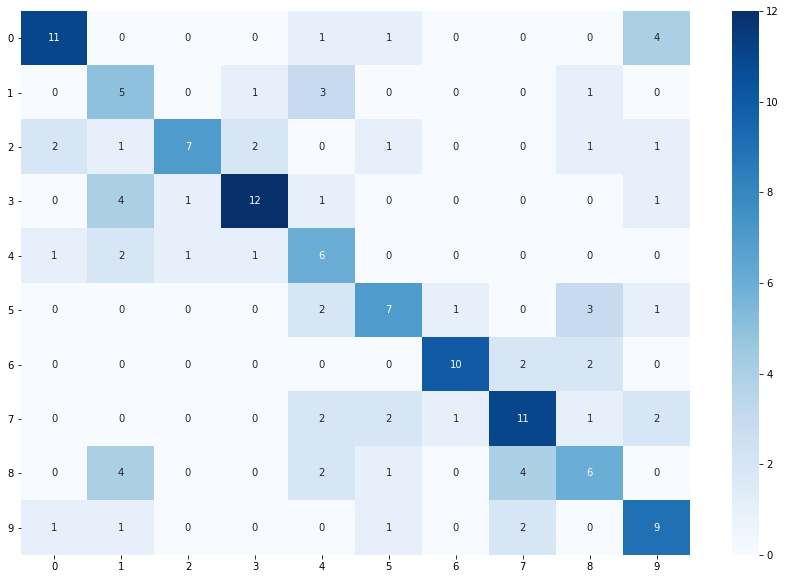

In [12]:
y_pred = clf_zcr.predict(X_test_zcr)

#Testing the model With ZCR
# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
#print(cm)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.yticks(rotation=0) 
plt.show()

Aggiungendo ZCR alla combo si ottiene un aumento di $10\%$ sull'accuratezza del modello sul test set.

# MFCC Prova

In [13]:
def mfcc(input, rate=8000, min_len=40, sampling=1):
    # Campiona i valori
    signal = input[::sampling]
    # Calcola coefficienti MFCC
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    # Applica eventuali zeri aggiuntivi per raggiungere una lunghezza fissa
    pad_width = min_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    # Appiattisci rappresentazione per uso con SVM
    mfcc = mfcc.flatten()
    return mfcc

In [14]:
def combo_with_mfcc(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input), mfcc(input)))

In [15]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_with_mfcc)

In [16]:
# Parametri da provare in cross validation
param_grid = {'C': [0.1, 1, 10, 100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Inizializzazione Support Vector Machine
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=3)

# Addestramento
t0 = time()
clf = clf.fit(X_train, y_train)
print('best parameters', clf.best_params_)
print("Addestramento completato in %0.3fs" % (time() - t0))

/home/pranav/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters {'C': 10, 'gamma': 0.005}
Addestramento completato in 141.360s


Report di classificazione:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        17
           1      1.000     1.000     1.000        10
           2      1.000     1.000     1.000        15
           3      1.000     1.000     1.000        19
           4      1.000     1.000     1.000        11
           5      1.000     0.929     0.963        14
           6      0.824     1.000     0.903        14
           7      1.000     0.947     0.973        19
           8      1.000     1.000     1.000        17
           9      1.000     0.929     0.963        14

    accuracy                          0.980       150
   macro avg      0.982     0.980     0.980       150
weighted avg      0.984     0.980     0.981       150

Matrice di confusione:


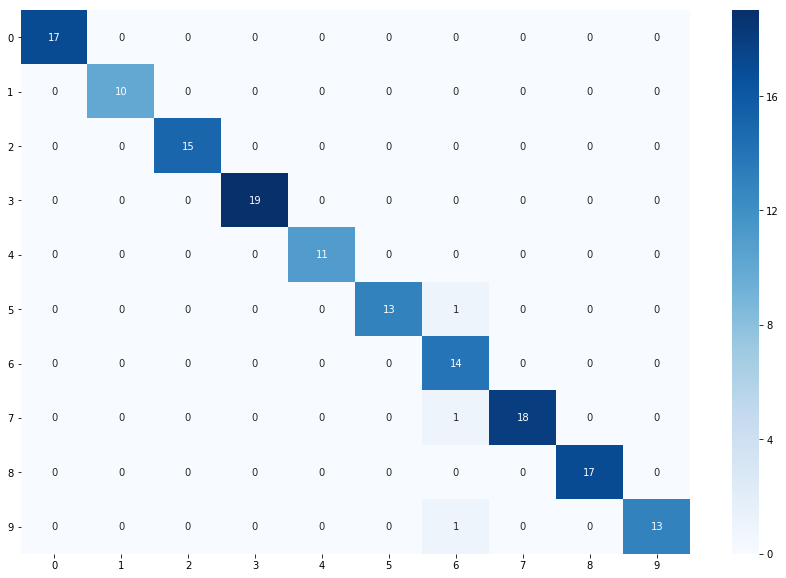

In [17]:
y_pred = clf.predict(X_test)

# Report di classificazione
print("Report di classificazione:")
print(classification_report(y_test, y_pred, digits=3))

# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
#print(cm)
plt.figure(figsize=(15,10))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.yticks(rotation=0) 
plt.show()

Con MFCC accuratezza arriva al $98\%$ 